In [1]:
import os
import time
import warnings
import numpy as np
import torch
import rasterio
import cv2
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import src

warnings.filterwarnings('ignore')

In [2]:
OEM_DATA_DIR = Path('data/processing/OpenEarthMap_Mini')
TRAIN_LIST = OEM_DATA_DIR.joinpath('train.txt')
VAL_LIST = OEM_DATA_DIR.joinpath('val.txt')

In [3]:
IMG_SIZE = 512
N_CLASSES = 9
LR = 3e-4
BATCH_SIZE = 4
NUM_EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUTPUT_DIR = Path('outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
fns = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in fns if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in fns if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(fns))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


In [5]:
train_augm = torchvision.transforms.Compose(
    [
        src.transforms.Rotate(),
        src.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        src.transforms.Resize(IMG_SIZE),
    ],
)

In [6]:
train_data = src.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = src.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

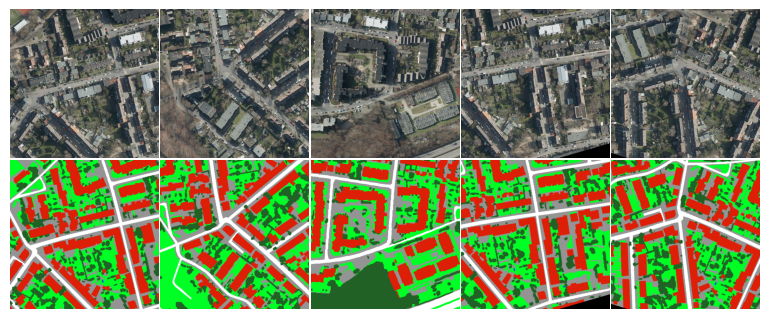

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = src.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [8]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)

val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

In [9]:
# network = src.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = src.networks.UnetPlusPlus(encoder_name='resnet18', encoder_weights='imagenet', in_channels=3, classes=N_CLASSES, activation='softmax')
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
# criterion = oem.losses.JaccardLoss()
# criterion = src.losses.FocalLoss()
criterion = src.custom_loss.BalancedTverskyFocalLoss()

In [10]:
log_run = False
import neptune
if log_run:
    run = neptune.init_run(
        project='gillan-k/mini-oem',
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyYWRiZGVlNC04NjA2LTRlMmYtODE4OS0zYWQ4NjFhYTEyMDIifQ==",
    )

In [11]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = src.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = src.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    if log_run:
        run['train/loss'] = train_logs['Loss']
        # run['train/iou'] = train_logs['IOU']
        run['train/fscore'] = train_logs['fscore']
        run['val/loss'] = train_logs['Loss']
        run['val/fscore'] = train_logs['fscore']
    
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        src.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Train:   2%|▏         | 4/165 [01:25<55:09, 20.55s/it, Loss=7.42, fscore=0.098]   

In [ ]:
if log_run:
    run.stop()

In [ ]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")
PREDS_DIR = "predictions"
os.makedirs(PREDS_DIR, exist_ok=True)

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

In [ ]:
# test_data = src.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

In [ ]:
# network = src.networks.UNet(in_channels=3, n_classes=N_CLASSES)
# network = src.utils.load_checkpoint(network, model_name="model.pth", model_dir="outputs")

In [ ]:
# NPLOT = 6
# idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

# fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
# fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

# network.eval().to(DEVICE)
# for i, idx in enumerate(idxs):
#     img, fn = test_data[idx][0], test_data[idx][2]

#     with torch.no_grad():
#         prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
#     prd = src.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

#     fout = os.path.join(PREDS_DIR, fn.split("/")[-1])
#     with rasterio.open(fn, "r") as f:
#         profile = f.profile
#         prd = cv2.resize(
#             prd,
#             (profile["width"], profile["height"]),
#             interpolation=cv2.INTER_NEAREST,
#         )
#         with rasterio.open(fout, "w", **profile) as dst:
#             for idx in f.indexes:
#                 dst.write(prd[:, :, idx - 1], idx)

#     img = np.moveaxis(img.numpy(), 0, -1)
#     axs[0, i].imshow(img)
#     axs[0, i].set_title(fn.split("/")[-1][:-4])    
#     axs[0, i].axis("off")
#     axs[1, i].imshow(prd)
#     axs[1, i].axis("off")